In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from typing import List, Tuple, Optional
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import numpy as np
from dataclasses import dataclass
from typing import Optional, Tuple, Iterable
import tensorflow as tf

Let's add helpers for Data Cleaning

In [71]:
# # Youssef's Config - Always Push with this one
from tf_keras import layers, callbacks, regularizers
import tf_keras as keras

# Mohamed's Config
# from tensorflow import keras
# from tensorflow.keras import layers, callbacks, regularizers

def _set_seed(seed: int = 42):
    np.random.seed(seed)
    tf.random.set_seed(seed)


def _build_ffnn(input_dim: int,
                hidden_units: Iterable[int] = (256, 128, 64),
                dropout: float = 0.10,
                l2: float = 1e-4,
                lr: float = 1e-3) -> keras.Model:
    reg = regularizers.l2(l2) if l2 and l2 > 0 else None
    model = keras.Sequential(name="ffnn_regressor")
    model.add(layers.Input(shape=(input_dim,)))
    for h in hidden_units:
        model.add(layers.Dense(h, activation="relu", kernel_regularizer=reg))
        if dropout and dropout > 0:
            model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation="linear"))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=[keras.metrics.RootMeanSquaredError(name="rmse"),
                 keras.metrics.MeanAbsoluteError(name="mae")]
    )
    return model

from typing import Optional, Tuple, Iterable, Dict, Any
from dataclasses import dataclass, field

@dataclass
class FFNNRegressor:
    # Hyperparams
    hidden_units: Tuple[int, ...] = (512, 256, 128, 64, 32, 16)
    dropout: float = 0.10
    l2: float = 1e-4
    lr: float = 1e-3
    epochs: int = 500
    batch_size: int = 1024
    patience: int = 30
    seed: int = 42
    verbose: int = 1

    # Fitted artifacts
    model: Optional[keras.Model] = None
    
    
        # raw keras History.history dict after training
    history: Dict[str, Any] = field(default_factory=dict)

    # nice cleaned view for plotting later (rmse per epoch etc.)
    history_: Dict[str, Any] = field(default_factory=dict)

    def fit(self,
            X_train: np.ndarray, y_train: np.ndarray,
            X_valid: np.ndarray, y_valid: np.ndarray):
        _set_seed(self.seed)

        # Ensure numeric arrays + handle NaNs/Infs
        X_train = np.nan_to_num(np.asarray(X_train, dtype=np.float32), nan=0.0, posinf=0.0, neginf=0.0)
        X_valid = np.nan_to_num(np.asarray(X_valid, dtype=np.float32), nan=0.0, posinf=0.0, neginf=0.0)
        y_train = np.asarray(y_train, dtype=np.float32).reshape(-1, 1)
        y_valid = np.asarray(y_valid, dtype=np.float32).reshape(-1, 1)

        # Build & train
        self.model = _build_ffnn(
            input_dim=X_train.shape[1],
            hidden_units=self.hidden_units,
            dropout=self.dropout,
            l2=self.l2,
            lr=self.lr,
        )

        cbs = [
            callbacks.EarlyStopping(
                monitor="val_rmse", mode="min",
                patience=self.patience, restore_best_weights=True
            ),
            callbacks.ReduceLROnPlateau(
                monitor="val_rmse", mode="min",
                factor=0.5, patience=max(5, self.patience // 3),
                min_lr=1e-6, verbose=1 if self.verbose else 0
            )
        ]

        hist = self.model.fit(
            X_train, y_train,
            validation_data=(X_valid, y_valid),
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=self.verbose,
            callbacks=cbs,
            shuffle=True
        )
        
        self.history = hist.history

        # 2. Derive a clean RMSE/MSE summary for plotting
        # prefer rmse if available because you already asked Keras to compute it
        train_rmse = self.history.get("rmse")
        val_rmse   = self.history.get("val_rmse")

        if train_rmse is not None and val_rmse is not None:
            # use direct rmse curves
            self.history_ = {
                "train_rmse": train_rmse,
                "val_rmse": val_rmse,
            }
        else:
            # fall back to sqrt(MSE) from loss if needed
            train_mse = self.history.get("loss", [])
            val_mse   = self.history.get("val_loss", [])
            self.history_ = {
                "train_mse": train_mse,
                "val_mse": val_mse,
                "train_rmse": [m ** 0.5 for m in train_mse],
                "val_rmse":   [m ** 0.5 for m in val_mse],
            }
        
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        X = np.nan_to_num(np.asarray(X, dtype=np.float32), nan=0.0, posinf=0.0, neginf=0.0)
        preds = self.model.predict(X, verbose=0).reshape(-1)
        return preds

In [72]:
def season_start_year(season_str: str) -> int:
    s = str(season_str)
    try:
        return int(s.split("-")[0])
    except Exception:
        return int(float(s))
    
def plot_learning_curves(model) -> None:
    """
    Plots train vs validation RMSE over training steps.

    Supports:
    - CatBoost models (via model.get_evals_result())
    - FFNNRegressor models (expects model.history_ with 'train_rmse' and 'val_rmse')

    Assumptions for FFNN:
    - model.history_ is a dict like:
        {
            "train_rmse": [rmse_epoch_1, rmse_epoch_2, ...],
            "val_rmse":   [rmse_epoch_1, rmse_epoch_2, ...],
        }
      OR
        {
            "train_mse": [...],
            "val_mse": [...],
        } and we take sqrt.
    """

    train_curve = None
    valid_curve = None
    x_axis_label = "Iteration"

    # -------- Try CatBoost-style first --------
    if hasattr(model, "get_evals_result"):
        try:
            evals = model.get_evals_result()
        except Exception:
            evals = None

        if evals:
            learn_rmse = evals.get("learn", {}).get("RMSE", None)
            valid_rmse = None
            if "validation" in evals:
                valid_rmse = evals["validation"].get("RMSE", None)
            elif "validation_0" in evals:
                valid_rmse = evals["validation_0"].get("RMSE", None)

            if learn_rmse is not None and valid_rmse is not None:
                train_curve = learn_rmse
                valid_curve = valid_rmse
                x_axis_label = "Iteration"

    # -------- Try FFNNRegressor-style next --------
    if train_curve is None and hasattr(model, "history_"):
        hist = getattr(model, "history_", None)

        if isinstance(hist, dict):
            # Preferred: explicit RMSEs captured during training
            if "train_rmse" in hist and "val_rmse" in hist:
                train_curve = hist["train_rmse"]
                valid_curve = hist["val_rmse"]
                x_axis_label = "Epoch"

            # Fallback: we only have train_mse / val_mse or train_loss / val_loss (MSE)
            elif "train_mse" in hist and "val_mse" in hist:
                train_curve = np.sqrt(hist["train_mse"])
                valid_curve = np.sqrt(hist["val_mse"])
                x_axis_label = "Epoch"
            elif "loss" in hist and "val_loss" in hist:
                # Assuming loss is MSE
                train_curve = np.sqrt(hist["loss"])
                valid_curve = np.sqrt(hist["val_loss"])
                x_axis_label = "Epoch"

    # -------- If still nothing, bail gracefully --------
    if train_curve is None or valid_curve is None:
        print(
            "No train/val RMSE history available.\n"
            "For FFNNRegressor, make sure .history_ exists and contains either:\n"
            "  - 'train_rmse' and 'val_rmse', or\n"
            "  - 'train_mse' and 'val_mse', or\n"
            "  - 'loss' and 'val_loss' (MSE)."
        )
        return

    # -------- Plot --------
    iters = range(1, len(train_curve) + 1)

    plt.figure(figsize=(7, 4.5))
    plt.plot(iters, train_curve, label="Train RMSE")
    plt.plot(iters, valid_curve, label="Valid RMSE")
    plt.xlabel(x_axis_label)
    plt.ylabel("RMSE")
    plt.title("Learning Curves")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [73]:
def drop_columns_save_interim(
    df: pd.DataFrame,
    cols_to_drop: list = None,
    filename: str = "dataset",
    output_subdir: str = "interim",
) -> pd.DataFrame:
    """
    Drops specified columns from a DataFrame.
    Saves the cleaned DataFrame in ../data/interim relative to this script.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    cols_to_drop : list, optional
        Columns to Drop, by default None
    filename : str, optional
        Base name for saved CSV files (default is 'dataset').
    output_subdir : str, optional
        Subdirectory inside /data (default is 'interim').

    Returns
    -------
    pd.DataFrame
        The cleaned DataFrame with specified columns removed.
    """

    # Determine absolute path: ../data/interim relative to this script
    script_dir = os.path.dirname(os.getcwd())
    data_dir = os.path.abspath(os.path.join(script_dir, "..", "data", output_subdir))

    # Ensure directories exist
    os.makedirs(data_dir, exist_ok=True)

    # Drop them from the main DataFrame
    df_reduced = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

    # Build save paths
    cleaned_path = os.path.join(data_dir, f"{filename}_post_drop.csv")

    # Save both files
    df_reduced.to_csv(cleaned_path, index=False)

    print(f"Cleaned file saved to: {cleaned_path}")

    return df_reduced

def normalize_position_column(
    df: pd.DataFrame,
    column: str = "position",
    filename: str = "dataset",
    output_subdir: str = "interim",
) -> pd.DataFrame:
    """
    Normalizes position values — e.g., replaces 'GKP' with 'GK' — and saves the cleaned dataset.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    column : str, optional
        The column to normalize (default is 'position').
    filename : str, optional
        Base name for saved file (default is 'dataset').
    output_subdir : str, optional
        Subdirectory under /data to save (default is 'interim').

    Returns
    -------
    pd.DataFrame
        Updated DataFrame with normalized position values.
    """

    # Determine save path (../data/interim)
    script_dir = os.path.dirname(os.path.abspath(os.getcwd()))
    data_dir = os.path.abspath(os.path.join(script_dir, "..", "data", output_subdir))
    os.makedirs(data_dir, exist_ok=True)

    df = df.copy()
    df[column] = df[column].apply(lambda x: "GK" if x == "GKP" else x)

    # Save cleaned file
    cleaned_path = os.path.join(data_dir, f"{filename}_normalized.csv")
    df.to_csv(cleaned_path, index=False)

    return df



from typing import List, Optional
from pathlib import Path
import pandas as pd

def drop_duplicates_by_keys_save_interim(
    df: pd.DataFrame,
    filename: str = "dataset",
    output_subdir: str = "interim",
    key_cols: Optional[List[str]] = None,
    print_max: int = 25,
    project_root: Optional[str] = None,             # e.g. r"C:\Users\mohmd\OneDrive\Desktop\ACL-2025\FPL-ACL-Team-28"
    project_root_name: str = "FPL-ACL-Team-28",     # used when project_root is not provided
) -> pd.DataFrame:
    """
    De-duplicate by (season, name, round, opponent team) and save to:
        <FPL-ACL-Team-28>/data/<output_subdir>/
    """

    # ---------- Locate project root -> FPL-ACL-Team-28 ----------
    if project_root:
        root = Path(project_root).resolve()
    else:
        cwd = Path.cwd().resolve()
        root = None
        for base in [cwd, *cwd.parents]:
            if base.name == project_root_name:
                root = base
                break
        if root is None:
            raise FileNotFoundError(
                f"Couldn't find a parent folder named '{project_root_name}'. "
                f"Pass project_root=... explicitly."
            )

    data_dir = root / "data" / output_subdir
    data_dir.mkdir(parents=True, exist_ok=True)

    # ---------- Resolve key columns ----------
    cols = set(df.columns)
    opp_aliases = [
        "opponent_team", "op_team", "opponent", "opponent_name",
        "op_team_name", "opp_team", "opp", "opp_name"
    ]
    detected_opp = next((c for c in opp_aliases if c in cols), None)

    if key_cols is None:
        season_col = "season_x" if "season_x" in cols else ("season" if "season" in cols else None)
        if season_col is None: raise ValueError("Missing season column ('season_x' or 'season').")
        if "name" not in cols: raise ValueError("Missing 'name' column.")
        if "round" not in cols: raise ValueError("Missing 'round' column.")
        if detected_opp is None:
            raise ValueError("Missing opponent column. Tried: " + ", ".join(opp_aliases))
        key_cols = [season_col, "name", "round", detected_opp]
    else:
        missing = [c for c in key_cols if c not in cols]
        if missing:
            raise ValueError(f"Missing key columns in DataFrame: {missing}")

    # ---------- De-duplicate ----------
    total_before = len(df)
    dup_mask = df.duplicated(subset=key_cols, keep="first")
    removed_rows = df.loc[dup_mask].copy()
    df_clean = df.drop_duplicates(subset=key_cols, keep="first").reset_index(drop=True)
    total_after = len(df_clean)
    removed_count = len(removed_rows)

    # ---------- Save to FPL-ACL-Team-28/data/interim ----------
    cleaned_path = data_dir / f"{filename}_dedup.csv"
    removed_path = data_dir / f"{filename}_removed_duplicates.csv"
    df_clean.to_csv(cleaned_path, index=False)
    removed_rows.to_csv(removed_path, index=False)

    # ---------- Summary ----------
    print(f"[Dedup Summary] Keys = {key_cols}")
    print(f"Rows before: {total_before:,}")
    print(f"Rows after : {total_after:,}")
    print(f"Removed    : {removed_count:,}")
    print(f"Cleaned file saved to : {cleaned_path}")
    print(f"Removed rows saved to : {removed_path}")

    if removed_count > 0:
        print("\n[Removed rows preview]")
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            print(removed_rows.head(print_max))
        if removed_count > print_max:
            print(f"... ({removed_count - print_max} more not shown)")
    else:
        print("\nNo duplicates found based on the specified keys.")

    return df_clean


Let's add helpers to help us in feature engineering.

In [74]:
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
import json

def one_hot_encode_columns(
    df: pd.DataFrame,
    columns_to_encode: list,
    filename: str = "dataset",
    output_subdir: str = "interim",
    drop_first: bool = True,
) -> pd.DataFrame:
    """
    One-hot encodes specified categorical columns in the given DataFrame.
    Saves both the encoded DataFrame and a record of encoded column names.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing categorical columns.
    columns_to_encode : list
        List of column names to one-hot encode.
    filename : str, optional
        Base name for saved CSVs (default is 'dataset').
    output_subdir : str, optional
        Folder under /data where outputs will be saved (default is 'interim').
    drop_first : bool, optional
        Whether to drop the first level of each encoded variable
        (useful for regression models to avoid dummy-variable trap).

    Returns
    -------
    pd.DataFrame
        The transformed DataFrame with one-hot encoded columns.
    """

    # --- Setup directories ---
    root_data_dir = os.path.join(os.getcwd(), "data")
    output_folder = os.path.join(root_data_dir, output_subdir)
    os.makedirs(output_folder, exist_ok=True)

    # --- One-hot encode ---
    encoded_df = pd.get_dummies(df, columns=columns_to_encode, drop_first=drop_first)

    # --- Save outputs ---
    encoded_path = os.path.join(output_folder, f"{filename}_encoded.csv")

    encoded_df.to_csv(encoded_path, index=False)

    return encoded_df



def label_encode_column(
    df: pd.DataFrame,
    column: str,
    filename: str = "dataset",
    output_subdir: str = "interim",
) -> tuple[pd.DataFrame, LabelEncoder]:
    """
    Label-encodes a single categorical column (e.g., player names).

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    column : str
        Column name to label-encode.
    filename : str, optional
        Base name for reference/logging only (default is 'dataset').
    output_subdir : str, optional
        Folder under /data where outputs would be saved if persisted
        (kept here for signature consistency).

    Returns
    -------
    tuple[pd.DataFrame, LabelEncoder]
        - DataFrame with a new column '<column>_encoded'
        - The fitted LabelEncoder (for reverse mapping)
    """

    # Determine absolute path: ../data/interim relative to this script
    script_dir = os.path.dirname(os.path.abspath(os.getcwd()))
    data_dir = os.path.abspath(os.path.join(script_dir, "..", "data", output_subdir))

    os.makedirs(data_dir, exist_ok=True)

    le = LabelEncoder()
    df[f"{column}_encoded"] = le.fit_transform(df[column].astype(str))

    df = df.drop(columns=[column])

    print(f"Column '{column}' label-encoded → new column '{column}_encoded'")

    cleaned_path = os.path.join(data_dir, f"{filename}_label_encoded.csv")

    df.to_csv(cleaned_path, index=False)

    return df, le

def map_bool_to_int(
    df: pd.DataFrame,
    columns_to_map: list,
    filename: str = "dataset",
    output_subdir: str = "interim",
) -> pd.DataFrame:
    """
    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing categorical columns.
    columns_to_map : list
        List of column names to map to int.
    filename : str, optional
        Base name for saved CSVs (default is 'dataset').
    output_subdir : str, optional
        Folder under /data where outputs will be saved (default is 'interim').

    Returns
    -------
    pd.DataFrame
        The transformed DataFrame with mapped columns.
    """

    # --- Setup directories ---
    root_data_dir = os.path.join(os.getcwd(), "data")
    output_folder = os.path.join(root_data_dir, output_subdir)
    os.makedirs(output_folder, exist_ok=True)

    # --- Map bool values to int ---
    mapped_df = df.copy()
    for col in columns_to_map:
        mapped_df[col] = mapped_df[col].map(lambda x: 1 if str(x) == "True" else 0)

    # --- Save outputs ---
    mapped_path = os.path.join(output_folder, f"{filename}_mapped.csv")

    mapped_df.to_csv(mapped_path, index=False)

    return mapped_df


def add_form(
    df: pd.DataFrame,
    filename: str = "dataset",
    output_subdir: str = "interim",
    name_column: str = "name_encoded",
) -> pd.DataFrame:
    """
    Adds 'form' for each (name, season_x) as the average of the PREVIOUS `window`
    gameweeks' total_points, divided by `divisor`, using up to `min_periods` available
    past GWs (no leakage). Saves to ../data/<output_subdir>/<filename>.csv.

    Expects columns: ['name'/'name_encoded', 'season_x', 'round', 'total_points'] exactly.
    """
    window = 4
    divisor = 10.0
    min_periods = 1
    fill_strategy = "zero"

    required = [name_column, "season_x", "round", "total_points"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    out = df.copy()
    out["round"] = pd.to_numeric(out["round"], errors="coerce")
    out = out.sort_values([name_column, "season_x", "round"])

    form = (
        out.groupby([name_column, "season_x"])["total_points"]
           .apply(lambda s: s.shift(1).rolling(window, min_periods=min_periods).mean() / divisor)
           .reset_index(level=[0, 1], drop=True)
    )

    if fill_strategy == "zero":
        form = form.fillna(0.0)

    out["form"] = form

    script_dir = os.path.dirname(os.path.abspath(os.getcwd()))
    data_dir = os.path.abspath(os.path.join(script_dir, "..", "data", output_subdir))
    os.makedirs(data_dir, exist_ok=True)

    out_path = os.path.join(data_dir, f"{filename}.csv")
    out.to_csv(out_path, index=False)
    print(f"Form-added file saved to: {out_path}")

    return out

def add_team_and_opponent_goals(
    df: pd.DataFrame,
    filename: str = "dataset",
    output_subdir: str = "interim",
) -> pd.DataFrame:
    """
    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing categorical columns.
    filename : str, optional
        Base name for saved CSVs (default is 'dataset').
    output_subdir : str, optional
        Folder under /data where outputs will be saved (default is 'interim').

    Returns
    -------
    pd.DataFrame
        The transformed DataFrame with added features columns.
    """

    # --- Setup directories ---
    root_data_dir = os.path.join(os.getcwd(), "data")
    output_folder = os.path.join(root_data_dir, output_subdir)
    os.makedirs(output_folder, exist_ok=True)

    # --- Add Features ---
    df_with_features = df.copy()

    df_with_features['ally_goals'] = df_with_features.apply(
        lambda x: x['team_h_score'] if x['was_home'] == True else x['team_a_score'],
        axis=1
    )

    df_with_features['opponent_goals'] = df_with_features.apply(
        lambda x: x['team_a_score'] if x['was_home'] == True else x['team_h_score'],
        axis=1
    )

    # --- Save outputs ---
    mapped_path = os.path.join(output_folder, f"{filename}_mapped.csv")
    df_with_features.to_csv(mapped_path, index=False)

    return df_with_features

import pandas as pd
import os

def add_lag_features(
    df: pd.DataFrame,
    columns: list[str],
    lags: list[int] = [1, 2],
    filename: str = "dataset",
    output_subdir: str = "interim"
) -> pd.DataFrame:
    """
    Adds lag features (e.g., lag 1 and lag 2) for specified columns.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame, typically time-sorted.
    columns : list of str
        Columns to generate lag features for.
    lags : list of int, optional
        Lag steps to apply (default is [1, 2]).
    filename : str, optional
        Base name for saved CSV (default is 'dataset').
    output_subdir : str, optional
        Folder under /data where output is saved (default is 'interim').

    Returns
    -------
    pd.DataFrame
        DataFrame with new lag columns added.
    """
    # --- Setup directories ---
    root_data_dir = os.path.join(os.getcwd(), "data")
    output_folder = os.path.join(root_data_dir, output_subdir)
    os.makedirs(output_folder, exist_ok=True)

    # --- Add lag features ---
    df_with_lags = df.copy()
    for col in columns:
        if col not in df.columns:
            print(f"Skipping '{col}' — not found in DataFrame.")
            continue
        for lag in lags:
            df_with_lags[f"{col}_lag{lag}"] = df_with_lags[col].shift(lag)

    # --- Save outputs ---
    lagged_path = os.path.join(output_folder, f"{filename}_lagged.csv")
    df_with_lags.to_csv(lagged_path, index=False)

    return df_with_lags

def add_upcoming_total_points(
    df: pd.DataFrame,
    player_col: str = "name_encoded",
    season_col: str = "season_x",
    week_col: str = "round",
    points_col: str = "total_points",
) -> pd.DataFrame:
    """
    Adds a new column `upcoming_total_points` representing next week's points
    for each player-season, shifted by -1 in chronological order.
    """
    df_sorted = df.sort_values([player_col, season_col, week_col])
    df_sorted["upcoming_total_points"] = (
        df_sorted.groupby([player_col, season_col])[points_col].shift(-1)
    )
    df_sorted = df_sorted.dropna(subset=["upcoming_total_points"]).reset_index(drop=True)
    return df_sorted

def season_start_year(season_str: str) -> int:
    s = str(season_str)
    try:
        return int(s.split("-")[0])
    except Exception:
        return int(float(s))

def scale_all_numeric(
    df: pd.DataFrame,
    filename: str = "dataset",
    output_subdir: str = "interim",
    columns: Optional[List[str]] = None,      # None -> auto-detect numeric
    exclude: Optional[List[str]] = None,      # columns to leave untouched
    scaler_type: str = "standard",            # "standard" | "minmax" | "robust" | "maxabs"
    feature_range: Tuple[float, float] = (0.0, 1.0),  # only for "minmax"
    fit_on: Optional[pd.DataFrame] = None,    # fit scaler on this DF, then transform `df`
    save_scaler: bool = True,
    verbose: bool = True,
    data_root: Optional[Path] = None,         # allow explicit override like Path("/…/FPL-ACL-Team-28/data")
) -> tuple[pd.DataFrame, object, List[str]]:
    """
    Scales numeric columns and writes artifacts under <data_root>/<output_subdir>/ :
      - <filename>_scaled.csv
      - <filename>_scaler.pkl
      - <filename>_scaled_columns.json

    Returns (scaled_df, fitted_scaler, scaled_columns).
    """
    # ---- Resolve data root (script, notebook, or explicit) ----
    if data_root is None:
        if "PROJECT_ROOT" in globals():
            base = Path(globals()["PROJECT_ROOT"])
        elif "__file__" in globals():
            base = Path(__file__).resolve().parent.parent  # parent of scripts/
        else:
            base = Path.cwd()  # notebook fallback
        data_root = base / "data"

    output_folder = Path(data_root) / output_subdir
    output_folder.mkdir(parents=True, exist_ok=True)

    # ---- Decide which columns to scale ----
    if columns is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    else:
        numeric_cols = list(columns)

    if exclude:
        ex = set(exclude)
        numeric_cols = [c for c in numeric_cols if c not in ex]

    if not numeric_cols:
        if verbose:
            print("No numeric columns selected for scaling. Saving original DataFrame.")
        out_path = output_folder / f"{filename}_scaled.csv"
        df.to_csv(out_path, index=False)
        return df.copy(), None, []

    # ---- Choose scaler ----
    st = scaler_type.lower().strip()
    if st == "standard":
        scaler = StandardScaler()
    elif st == "minmax":
        scaler = MinMaxScaler(feature_range=feature_range)
    elif st == "robust":
        scaler = RobustScaler()
    elif st == "maxabs":
        scaler = MaxAbsScaler()
    else:
        raise ValueError("Unknown scaler_type. Use: 'standard' | 'minmax' | 'robust' | 'maxabs'.")

    # ---- Fit/transform ----
    fit_df = fit_on if fit_on is not None else df
    scaler.fit(fit_df[numeric_cols].astype(float).values)

    out = df.copy()
    out[numeric_cols] = scaler.transform(out[numeric_cols].astype(float).values)

    # ---- Save artifacts ----
    scaled_path = output_folder / f"{filename}_scaled.csv"
    out.to_csv(scaled_path, index=False)

    if save_scaler:
        pkl_path = output_folder / f"{filename}_scaler.pkl"
        with open(pkl_path, "wb") as f:
            pickle.dump({"scaler": scaler, "columns": numeric_cols, "scaler_type": st}, f)

        cols_json_path = output_folder / f"{filename}_scaled_columns.json"
        with open(cols_json_path, "w", encoding="utf-8") as f:
            json.dump({"columns": numeric_cols}, f, indent=2)

        if verbose:
            print(f"Saved scaler -> {pkl_path}")
            print(f"Saved scaled columns -> {cols_json_path}")

    if verbose:
        print(f"Scaled DataFrame saved to: {scaled_path}")
        print(f"Columns scaled ({len(numeric_cols)}): {numeric_cols}")

    return out, scaler, numeric_cols



Now we add the explainability functions of the shap and lime

In [75]:
# scripts/explainability.py
"""
Explainability utilities for the FPL project.

Defaults:
- SHAP background = 1024 rows (env override: SHAP_BACKGROUND_N)
- SHAP test points shown = 800 (env override: SHAP_TEST_POINTS)

Outputs:
- SHAP figures/CSV -> reports/figures/shap/
- LIME HTML/PNGs   -> reports/figures/lime/
"""

import os
from typing import List, Iterable, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SHAP & LIME
import shap
from lime.lime_tabular import LimeTabularExplainer

# Tunables (env overridable)
SHAP_BACKGROUND_N = int(os.getenv("SHAP_BACKGROUND_N", 800))
SHAP_TEST_POINTS  = int(os.getenv("SHAP_TEST_POINTS", 800))

# Detect CatBoost for fast TreeExplainer path (optional)
try:
    from catboost import CatBoostRegressor
    _HAS_CATBOOST = True
except Exception:
    _HAS_CATBOOST = False


# ---------- Path helpers ----------
def _project_root() -> str:
    # parent of scripts/
    try:
        # Try to use __file__ (works in .py scripts)
        return os.path.abspath(os.path.join(os.path.dirname(__file__), ".."))
    except NameError:
        # Fallback for Jupyter notebooks - use current working directory
        return os.getcwd()

def _ensure_dir(p: str) -> str:
    os.makedirs(p, exist_ok=True)
    return p

def _dir_reports() -> str:
    return _ensure_dir(os.path.join(_project_root(), "reports"))

def _dir_figures() -> str:
    # default save root: <project>/reports/figures
    # optional override via env var EXPLAIN_OUT_DIR
    base = os.environ.get("EXPLAIN_OUT_DIR", os.path.join(_dir_reports(), "figures"))
    return _ensure_dir(base)

def _dir_shap() -> str:
    return _ensure_dir(os.path.join(_dir_figures(), "shap"))

def _dir_lime() -> str:
    return _ensure_dir(os.path.join(_dir_figures(), "lime"))


# ---------- Small helpers ----------
def _predict_fn(model):
    """Return a callable f(X) -> 1D np.array for any regressor (CatBoost, Keras, sklearn-like)."""
    def f(X):
        if isinstance(X, pd.DataFrame):
            X_ = X.values
        else:
            X_ = X
        y = model.predict(X_)
        return np.asarray(y).reshape(-1)
    return f

def _sample_df(df: pd.DataFrame, n: int, seed: int = 42) -> pd.DataFrame:
    n = min(n, len(df))
    return df.sample(n=n, random_state=seed) if len(df) > n else df.copy()

def _indices_from_names(feature_names: List[str], selected: Iterable[str]) -> List[int]:
    """Map a list of feature names to their column indices; ignore missing with a warning."""
    selected = list(selected)
    name_to_i = {n: i for i, n in enumerate(feature_names)}
    idx = [name_to_i[n] for n in selected if n in name_to_i]
    missing = [n for n in selected if n not in name_to_i]
    if missing:
        print(f"[Explainability] Warning: missing features ignored: {missing}")
    return idx

def _subset_predict_fn(model,
                       all_feature_names: List[str],
                       subset_names: List[str],
                       anchor_full_row: np.ndarray):
    """
    Create a predict_fn(X_subset) that rebuilds full feature vectors by
    starting from 'anchor_full_row' and replacing only the subset columns.
    """
    subset_idx = _indices_from_names(all_feature_names, subset_names)
    full_predict = _predict_fn(model)

    anchor_full_row = np.asarray(anchor_full_row, dtype=float)
    anchor_full_row = np.nan_to_num(anchor_full_row, nan=0.0, posinf=0.0, neginf=0.0)

    def f(X_subset: np.ndarray):
        X_subset = np.asarray(X_subset, dtype=float)
        X_full = np.tile(anchor_full_row, (X_subset.shape[0], 1))
        X_full[:, subset_idx] = X_subset
        return full_predict(X_full)
    return f


# ---------- SHAP (global + local) ----------
def shap_global_summary(
    model,
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    model_name: str,
    feature_names: Optional[Iterable[str]] = None,
    max_background: int = SHAP_BACKGROUND_N,
    max_test_points: int = SHAP_TEST_POINTS,
    feature_whitelist: Optional[Iterable[str]] = None,
):
    """
    Creates global SHAP plots (beeswarm + bar) and a CSV of mean |SHAP|.
    If feature_whitelist is provided, explanations are restricted to exactly those features.
    Saves into reports/figures/shap/.
    """
    out_dir = _dir_shap()
    feature_names = list(feature_names or X_train.columns)

    # Background for SHAP (downsampled for speed)
    background = _sample_df(X_train, max_background)

    # Choose efficient explainer
    if _HAS_CATBOOST and isinstance(model, CatBoostRegressor):
        # Interventional SHAP recommended for tabular
        explainer = shap.TreeExplainer(
            model,
            data=background,
            feature_perturbation="interventional"
        )
        X_for_shap = _sample_df(X_test, max_test_points)
        shap_values = explainer(X_for_shap)
    else:
        masker = shap.maskers.Independent(background)
        explainer = shap.Explainer(_predict_fn(model), masker, algorithm="auto")
        X_for_shap = _sample_df(X_test, max_test_points)
        shap_values = explainer(X_for_shap)

    # Restrict to whitelist if provided
    if feature_whitelist:
        selected = [c for c in feature_whitelist if c in feature_names]
        if len(selected) == 0:
            print("[SHAP] feature_whitelist empty/invalid; falling back to all features.")
            selected = feature_names
        idx = _indices_from_names(feature_names, selected)
        shap_values = shap_values[:, idx]  # slice features
        feature_names = selected

    n_feats = len(feature_names)

    # Beeswarm — show the (restricted) features
    plt.figure()
    plt.gcf().set_size_inches(10, max(6, 0.35 * n_feats))
    shap.plots.beeswarm(shap_values, show=False, max_display=n_feats)
    plt.title(f"SHAP Beeswarm — {model_name}")
    beeswarm_path = os.path.join(out_dir, f"shap_beeswarm_{model_name}.png")
    plt.tight_layout(); plt.savefig(beeswarm_path, dpi=150); plt.close()

    # Bar — show the (restricted) features
    plt.figure()
    plt.gcf().set_size_inches(10, max(6, 0.35 * n_feats))
    shap.plots.bar(shap_values, show=False, max_display=n_feats)
    plt.title(f"SHAP Bar — {model_name}")
    bar_path = os.path.join(out_dir, f"shap_bar_{model_name}.png")
    plt.tight_layout(); plt.savefig(bar_path, dpi=150); plt.close()

    # CSV of global importance for the (restricted) features
    mean_abs = np.abs(shap_values.values).mean(axis=0)
    imp = (
        pd.DataFrame({"feature": feature_names, "mean_abs_shap": mean_abs})
        .sort_values("mean_abs_shap", ascending=False)
        .reset_index(drop=True)
    )
    csv_path = os.path.join(out_dir, f"shap_global_importance_{model_name}.csv")
    imp.to_csv(csv_path, index=False)

    print(f"[SHAP] Saved:\n  {beeswarm_path}\n  {bar_path}\n  {csv_path}")


def shap_local_waterfalls(
    model,
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    model_name: str,
    indices: List[int],
    max_background: int = SHAP_BACKGROUND_N,
    feature_whitelist: Optional[Iterable[str]] = None,
):
    """
    Saves SHAP waterfall plots for specified test rows into reports/figures/shap/.
    If feature_whitelist is provided, each instance waterfall shows only those features.
    """
    out_dir = _dir_shap()
    background = _sample_df(X_train, max_background)

    if _HAS_CATBOOST and isinstance(model, CatBoostRegressor):
        explainer = shap.TreeExplainer(
            model,
            data=background,
            feature_perturbation="interventional"
        )
    else:
        masker = shap.maskers.Independent(background)
        explainer = shap.Explainer(_predict_fn(model), masker, algorithm="auto")

    rows = X_test.iloc[indices]
    shap_values = explainer(rows)
    feature_names_full = list(X_train.columns)

    # Restrict to whitelist if provided (consistent order)
    if feature_whitelist:
        selected = [c for c in feature_whitelist if c in feature_names_full]
        if len(selected) == 0:
            print("[SHAP] feature_whitelist empty/invalid; falling back to all features.")
            selected = feature_names_full
        idx = _indices_from_names(feature_names_full, selected)
        shap_values = shap_values[:, idx]
        n_feats = len(selected)
    else:
        n_feats = X_test.shape[1]

    for j, i in enumerate(indices):
        plt.figure()
        plt.gcf().set_size_inches(10, max(6, 0.35 * n_feats))
        shap.plots.waterfall(shap_values[j], show=False, max_display=n_feats)
        fpath = os.path.join(out_dir, f"shap_waterfall_{model_name}_idx{int(i)}.png")
        plt.tight_layout(); plt.savefig(fpath, dpi=150); plt.close()
        print(f"[SHAP] Saved local waterfall for row {int(i)} -> {fpath}")


# ---------- LIME (local) ----------
def lime_local_explanations(
    model,
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    model_name: str,
    feature_names: Optional[Iterable[str]] = None,
    indices: List[int] = [0, 1, 2],
    num_features: Optional[int] = None,
    num_samples: int = 5000,
    feature_whitelist: Optional[Iterable[str]] = None,
):
    """
    Generates LIME explanations (HTML + PNG) for selected rows.
    Saves into reports/figures/lime/.
    Robust to zero-variance columns and NaNs/Infs.

    If feature_whitelist is given, LIME perturbs ONLY those features; all others
    are frozen to the instance's original values via a reconstructing predict_fn.
    """
    out_dir = _dir_lime()
    all_feature_names = list(feature_names or X_train.columns)

    # LIME-only sanitized copies (jitter constant cols; handle NaN/Inf) on ALL columns
    Xtr_s_all, Xte_s_all, constant_cols = _sanitize_for_lime(X_train, X_test, eps=1e-6)
    if len(constant_cols) > 0:
        print(f"[LIME] Detected zero-variance features (jittered for sampling): {list(constant_cols)}")

    # Determine subset to use
    if feature_whitelist:
        selected = [c for c in feature_whitelist if c in all_feature_names]
        if len(selected) == 0:
            print("[LIME] feature_whitelist empty/invalid; falling back to all features.")
            selected = all_feature_names
    else:
        selected = all_feature_names

    # Now restrict training/test matrices to the selected subset (order preserved)
    Xtr_s = Xtr_s_all[selected].copy()
    Xte_s = Xte_s_all[selected].copy()
    feature_names_subset = selected

    # num_features governs how many LIME coefficients are displayed
    if num_features is None or num_features <= 0:
        num_features = len(feature_names_subset)

    explainer = LimeTabularExplainer(
        training_data=Xtr_s.values,
        feature_names=feature_names_subset,
        mode="regression",
        discretize_continuous=False,  # avoid truncnorm issues
        sample_around_instance=True,
        random_state=42,
    )

    # If we restricted features, we need a predict_fn that rebuilds the full vector
    full_cols = list(X_train.columns)

    for i in indices:
        i = int(i)
        x0_subset = Xte_s.iloc[i].values.astype(float, copy=False)

        if feature_whitelist:
            predict = _subset_predict_fn(
                model=model,
                all_feature_names=full_cols,
                subset_names=feature_names_subset,
                anchor_full_row=Xte_s_all.iloc[i].values  # sanitized full row
            )
        else:
            predict = _predict_fn(model)

        exp = explainer.explain_instance(
            data_row=x0_subset,
            predict_fn=predict,
            num_features=min(num_features, len(feature_names_subset)),
            num_samples=num_samples,
        )

        html_path = os.path.join(out_dir, f"lime_{model_name}_idx{i}.html")
        exp.save_to_file(html_path)

        fig = exp.as_pyplot_figure()
        fig.set_size_inches(10, max(6, 0.35 * num_features))
        plt.title(f"LIME (regression) — {model_name} — row {i}")
        png_path = os.path.join(out_dir, f"lime_{model_name}_idx{i}.png")
        plt.tight_layout(); plt.savefig(png_path, dpi=150); plt.close(fig)

        print(f"[LIME] Saved:\n  {html_path}\n  {png_path}")


def _sanitize_for_lime(X_train: pd.DataFrame, X_test: pd.DataFrame, eps: float = 1e-6):
    """
    Prepare copies for LIME:
      - replace inf/NaN
      - add tiny jitter to zero-variance columns (so sampling has positive scale)
    Returns: Xtr_s, Xte_s, constant_cols (Index)
    """
    Xtr = X_train.copy()
    Xte = X_test.copy()

    # Replace inf/NaN (LIME will choke on them)
    Xtr = Xtr.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    Xte = Xte.replace([np.inf, -np.inf], np.nan).fillna(0.0)

    # Find zero-variance columns
    constant_cols = Xtr.columns[Xtr.nunique(dropna=False) <= 1]

    if len(constant_cols) > 0:
        # Add tiny Gaussian jitter ONLY for LIME's synthetic sampling
        rng = np.random.default_rng(42)
        Xtr.loc[:, constant_cols] = (
            Xtr.loc[:, constant_cols].to_numpy(dtype=float)
            + rng.normal(0.0, eps, size=(len(Xtr), len(constant_cols)))
        )
        Xte.loc[:, constant_cols] = (
            Xte.loc[:, constant_cols].to_numpy(dtype=float)
            + rng.normal(0.0, eps, size=(len(Xte), len(constant_cols)))
        )

    return Xtr, Xte, constant_cols


# ---------- Orchestrator ----------
def run_explainability(
    model,
    model_name: str,
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    feature_names: Optional[Iterable[str]] = None,
    local_rows: Optional[List[int]] = None,
    do_shap: bool = True,
    do_lime: bool = True,
    feature_whitelist: Optional[Iterable[str]] = None,
):
    """
    One-call convenience wrapper from main.py

    feature_whitelist: if provided, explanations (SHAP + LIME) are restricted
    to exactly these features (order preserved). Useful for "show only my 10".
    """
    feature_names = list(feature_names or X_train.columns)
    local_rows = local_rows or [0, 1, 2]

    if feature_whitelist:
        wl = [c for c in feature_whitelist if c in feature_names]
        print(f"[Explainability] Using feature whitelist ({len(wl)}): {wl}")

    if do_shap:
        shap_global_summary(
            model, X_train, X_test, model_name, feature_names,
            feature_whitelist=feature_whitelist
        )
        shap_local_waterfalls(
            model, X_train, X_test, model_name,
            indices=local_rows, feature_whitelist=feature_whitelist
        )

    if do_lime:
        # num_features=None => show ALL from the (restricted) set
        lime_local_explanations(
            model, X_train, X_test, model_name, feature_names,
            indices=local_rows, num_features=None,
            feature_whitelist=feature_whitelist
        )

Let's add a helper that will be used to visualize the splitting of the data

In [76]:
def summarize_round_splits(
    df: pd.DataFrame,
    train_idx: pd.Index,
    valid_idx: pd.Index,
    test_idx: pd.Index,
    season_col: str = "season_x",
    week_col: str = "round",
) -> pd.DataFrame:
    """
    For each season, list which rounds belong to TRAIN / VALID / TEST.
    Prints a compact view and returns a summary DataFrame.
    """
    df2 = df[[season_col, week_col]].copy()
    df2["_subset"] = "UNASSIGNED"
    df2.loc[train_idx.intersection(df2.index), "_subset"] = "TRAIN"
    df2.loc[valid_idx.intersection(df2.index), "_subset"] = "VALID"
    df2.loc[test_idx.intersection(df2.index),  "_subset"] = "TEST"

    # Keep only assigned rows
    df2 = df2[df2["_subset"] != "UNASSIGNED"]

    # Build per-season summary
    rows = []
    for season, g in df2.groupby(season_col, sort=True):
        out = {"season": season}
        for subset in ["TRAIN", "VALID", "TEST"]:
            rounds = sorted(g.loc[g["_subset"] == subset, week_col].unique().tolist())
            if rounds:
                rng = f"{min(rounds)}–{max(rounds)}"
                # If you also want the exact list uncomment next line:
                # out[f"{subset}_rounds_list"] = rounds
                out[f"{subset}_rounds"] = rng
                out[f"{subset}_count"] = len(rounds)
            else:
                out[f"{subset}_rounds"] = "—"
                out[f"{subset}_count"] = 0

        # Simple temporal sanity flags
        def _minmax(sub):
            r = g.loc[g["_subset"] == sub, week_col]
            return (r.min(), r.max()) if len(r) else (None, None)

        tr_min, tr_max = _minmax("TRAIN")
        va_min, va_max = _minmax("VALID")
        te_min, te_max = _minmax("TEST")

        # Check monotonic order: TRAIN ≤ VALID ≤ TEST (where present)
        ok_train_valid = (tr_max is None or va_min is None) or (tr_max <= va_min)
        ok_valid_test  = (va_max is None or te_min is None) or (va_max <= te_min)
        out["order_ok"] = bool(ok_train_valid and ok_valid_test)

        rows.append(out)

    summary = pd.DataFrame(rows).sort_values("season").reset_index(drop=True)

    # Pretty print
    print("\nRound allocation by season (min–max rounds per subset):")
    for _, r in summary.iterrows():
        print(
            f"  {r['season']}: "
            f"TRAIN {r['TRAIN_rounds']} ({r['TRAIN_count']}) | "
            f"VALID {r['VALID_rounds']} ({r['VALID_count']}) | "
            f"TEST {r['TEST_rounds']} ({r['TEST_count']}) "
            f"| order_ok={r['order_ok']}"
        )

    return summary

First let's import our raw data before any data cleaning or feature engineering.

In [77]:
df = pd.read_csv('../data/raw/cleaned_merged_seasons.csv', low_memory=False)

We start our Feature Engineering process by adding 2 columns, a column called 'Team Goals' and another called 'Opponent Goals', it is a way for the model to understand which team is the player's and which team is the Opponents instead of the interaction feature between was_home and home_team_goals and away_team_goals.

We will report our performance with and without it. 

Finally let's add helpers to help us in training our model.

In [78]:
def train_ffnn(
    X_train, y_train, X_valid, y_valid,
    params: Optional[dict] = None
):
    """
    Initializes and trains a feed-forward neural network for regression.
    Returns a model with a .predict(...) method for compatibility with your evaluate_model().
    """
    if params is None:
        params = {
            "hidden_units": (256, 128, 64,32),
            "dropout": 0.10,
            "l2": 1e-4,
            "lr": 1e-3,
            "epochs": 400,
            "batch_size": 1024,
            "patience": 25,
            "seed": 42,
            "verbose": 0,
        }
    model = FFNNRegressor(**params)
    hist = model.fit(X_train, y_train, X_valid, y_valid)
    
    history = {
    "train_rmse": np.sqrt(hist.history["loss"]),
    "val_rmse":   np.sqrt(hist.history["val_loss"]),
    }
    
    return model, history


def build_xy(
    df: pd.DataFrame,
    target_col: str = "upcoming_total_points",
    drop_cols: Optional[List[str]] = None,
    keep_player_id: bool = True,
    player_col: str = "name_encoded",
) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separates features (X) and target (y).
    If keep_player_id=True, keeps `name_encoded` in X.
    """
    if drop_cols is None:
        drop_cols = ["season_x", "round"]

    if not keep_player_id:
        drop_cols = drop_cols + [player_col]

    feature_cols = [c for c in df.columns if c not in drop_cols + [target_col]]
    X = df[feature_cols]
    y = df[target_col]
    return X, y

def evaluate_model(
    model,
    X_test: pd.DataFrame, y_test: pd.Series,
    X_train: pd.DataFrame = None, y_train: pd.Series = None,
    X_valid: pd.DataFrame = None, y_valid: pd.Series = None,
) -> dict:
    def _metrics(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

    report = {}

    if X_train is not None and y_train is not None:
        preds_tr = model.predict(X_train)
        report["train"] = _metrics(y_train, preds_tr)

    if X_valid is not None and y_valid is not None:
        preds_val = model.predict(X_valid)
        report["valid"] = _metrics(y_valid, preds_val)

    preds_te = model.predict(X_test)
    report["test"] = _metrics(y_test, preds_te)

    # Pretty print
    print("\n📊 Evaluation Metrics:")
    for split in ["train", "valid", "test"]:
        if split in report:
            m = report[split]
            print(f"  {split.upper()}:  MAE={m['MAE']:.4f}  RMSE={m['RMSE']:.4f}  R2={m['R2']:.4f}")

    return report

def auto_global_temporal_split_inseason(
    df: pd.DataFrame,
    season_col: str = "season_x",
    week_col: str = "round",
    train_frac: float = 0.8,
    valid_frac: float = 0.1,
    test_frac: float = 0.1,
    split_train_valid: bool = True,
    split_valid_test: bool = True,
    ratio_train_valid: float = 0.5,  # e.g., 0.5 ⇒ first half of boundary season to TRAIN, rest to VALID
    ratio_valid_test: float = 0.5,   # e.g., 0.5 ⇒ first half of boundary season to VALID, rest to TEST
) -> Tuple[pd.Index, pd.Index, pd.Index, List[int]]:
    """
    Global chronological split by season start year, with optional *within-season* (by rounds) splitting
    at the TRAIN↔VALID boundary and/or VALID↔TEST boundary.

    If TRAIN and VALID touch the same season:
        - earlier rounds (<= floor(ratio_train_valid * max_round_in_that_season)) → TRAIN
        - later  rounds  (> ...) → VALID

    If VALID and TEST touch the same season:
        - earlier rounds (<= floor(ratio_valid_test * max_round_in_that_season)) → VALID
        - later  rounds  (> ...) → TEST

    Guarantees non-empty buckets when n_seasons ≥ 3.
    """
    assert abs(train_frac + valid_frac + test_frac - 1.0) < 1e-9, "Fractions must sum to 1."

    years = sorted({season_start_year(s) for s in df[season_col].unique()})
    n = len(years)
    if n < 3:
        raise ValueError("Need at least 3 distinct seasons for train/valid/test.")

    # Base year cuts (use floor; keep at least 1 season per bucket)
    cut1 = max(1, int(np.floor(n * train_frac)))
    cut2 = max(cut1 + 1, int(np.floor(n * (train_frac + valid_frac))))
    if cut2 >= n:  # ensure non-empty test
        cut2 = n - 1

    years_train_list = years[:cut1]
    years_valid_list = years[cut1:cut2]
    years_test_list  = years[cut2:]

    # If valid ended empty, steal one from train
    if len(years_valid_list) == 0:
        years_train_list = years[:cut1-1]
        years_valid_list = [years[cut1-1]]
        years_test_list  = years[cut1:]

    years_train, years_valid, years_test = set(years_train_list), set(years_valid_list), set(years_test_list)

    df2 = df.copy()
    df2["_year"] = df2[season_col].map(season_start_year)
    df2 = df2.sort_values([season_col, week_col], kind="mergesort")

    # Initial whole-season masks
    train_mask = df2["_year"].isin(years_train)
    valid_mask = df2["_year"].isin(years_valid)
    test_mask  = df2["_year"].isin(years_test)

    # Helper: move early/late rounds between masks for a *single* boundary season
    def split_boundary(season_year: int, early_to: str, ratio: float):
        # max round for that season (across all players)
        season_rows = (df2["_year"] == season_year)
        if not season_rows.any():
            return
        max_round = int(df2.loc[season_rows, week_col].max())
        thr = max(1, int(np.floor(ratio * max_round)))  # e.g., 38 * 0.5 ⇒ 19

        early_rows = season_rows & (df2[week_col] <= thr)
        late_rows  = season_rows & (df2[week_col] >  thr)

        # Clear current assignment for that season
        nonlocal train_mask, valid_mask, test_mask
        train_mask = train_mask & (~season_rows)
        valid_mask = valid_mask & (~season_rows)
        test_mask  = test_mask  & (~season_rows)

        # Reassign early/late to the two adjacent sets
        if early_to == "train":         # TRAIN | VALID boundary
            train_mask |= early_rows
            valid_mask |= late_rows
        elif early_to == "valid":       # VALID | TEST boundary
            valid_mask |= early_rows
            test_mask  |= late_rows
        else:
            raise ValueError("early_to must be 'train' or 'valid'.")

    # TRAIN↔VALID boundary season = first VALID season (if any)
    if split_train_valid and len(years_valid_list) > 0:
        b1 = years_valid_list[0]
        # Only split if TRAIN and VALID are adjacent seasons (i.e., boundary not separated by gaps is fine)
        # This always holds by construction; we just apply the half-split.
        split_boundary(b1, early_to="train", ratio=ratio_train_valid)

    # VALID↔TEST boundary season = first TEST season (if any)
    if split_valid_test and len(years_test_list) > 0:
        b2 = years_test_list[0]
        split_boundary(b2, early_to="valid", ratio=ratio_valid_test)

    # Final indices
    train_idx = df2.index[train_mask]
    valid_idx = df2.index[valid_mask]
    test_idx  = df2.index[test_mask]

    # Safety: ensure non-empty
    if len(train_idx) == 0 or len(valid_idx) == 0 or len(test_idx) == 0:
        # Fallback to strict season buckets (last two seasons valid/test)
        years_train = set(years[:-2]); years_valid = {years[-2]}; years_test = {years[-1]}
        base = df2.copy()
        train_idx = base[base["_year"].isin(years_train)].index
        valid_idx = base[base["_year"].isin(years_valid)].index
        test_idx  = base[base["_year"].isin(years_test)].index

    return train_idx, valid_idx, test_idx, years

In [79]:
def build_dataset(cols_to_drop_override=None, use_form=True, use_lags=True):
    """
    Rebuilds the dataset end-to-end with knobs for dropping columns,
    toggling form, and toggling lag features.
    Returns: X_train, y_train, X_valid, y_valid, X_test, y_test
    """
    cols_to_drop_local = BASE_COLS_TO_DROP if cols_to_drop_override is None else cols_to_drop_override
    
    _df = drop_columns_save_interim(df, cols_to_drop_local)
    _df = normalize_position_column(_df)
    _df, _ = label_encode_column(_df, column="name")
    _df = one_hot_encode_columns(_df, ["position"])
    _df = map_bool_to_int(_df, ['was_home', 'position_FWD', 'position_MID', 'position_GK'])
    
    if use_form:
        _df = add_form(_df)

    lag_candidates = [
        'assists', 'bonus', 'bps', 'clean_sheets',
        'goals_conceded', 'goals_scored', 'ict_index',
        'minutes', 'saves', 'yellow_cards', 'ally_goals', 'opponent_goals',
    ]
    if use_lags:
        existing = [c for c in lag_candidates if c in _df.columns]
        _df = add_lag_features(_df, existing)
    
    _df = add_upcoming_total_points(_df)
    
    X_, y_ = build_xy(_df, keep_player_id=True, player_col="name_encoded")
    
    if 'total_points' in X_.columns:
        X_ = X_.drop(columns=['total_points'])
    
    train_idx, valid_idx, test_idx, _ = auto_global_temporal_split_inseason(
        _df,
        season_col="season_x",
        week_col="round",
        train_frac=0.8, valid_frac=0.1, test_frac=0.1,
        split_train_valid=True, ratio_train_valid=0.8,
        split_valid_test=True, ratio_valid_test=0.5,
    )
    X_tr, y_tr = X_.loc[train_idx].copy(), y_.loc[train_idx].copy()
    X_va, y_va = X_.loc[valid_idx].copy(), y_.loc[valid_idx].copy()
    X_te, y_te = X_.loc[test_idx].copy(), y_.loc[test_idx].copy()
    
    for D in (X_tr, X_va, X_te):
        if "name_encoded" in D.columns:
            D.drop(columns=["name_encoded"], inplace=True)
    
    return X_tr, y_tr, X_va, y_va, X_te, y_te


def run_one(label, cols_to_drop_override=None, use_form=True, use_lags=True):    
    X_tr, y_tr, X_va, y_va, X_te, y_te = build_dataset(
        cols_to_drop_override=cols_to_drop_override,
        use_form=use_form,
        use_lags=use_lags
    )
    
    X_tr = X_tr.select_dtypes(include=[np.number])
    X_va = X_va.select_dtypes(include=[np.number])
    X_te = X_te.select_dtypes(include=[np.number])
    
    model, history = train_ffnn(X_tr, y_tr, X_va, y_va)
    rep = evaluate_model(model, X_te, y_te, X_tr, y_tr, X_va, y_va)
    
    valid_mae = rep["valid"]["MAE"]
    test_mae = rep["test"]["MAE"]
    print(f"[{label}] valid_MAE={valid_mae:.4f}, test_MAE={test_mae:.4f}")
    
    return {
        "label": label,
        "valid_MAE": rep["valid"]["MAE"],
        "test_MAE": rep["test"]["MAE"]
    }

def drop_cols_with_prefix(df_like, prefix):
    return [c for c in df_like.columns if c.startswith(prefix)]

def run_no_position_dummies():
    X_tr, y_tr, X_va, y_va, X_te, y_te = build_dataset()
    drop_pos = [c for c in X_tr.columns if c.startswith("position_")]
    for D in (X_tr, X_va, X_te):
        D.drop(columns=drop_pos, inplace=True, errors="ignore")
    model, history = train_ffnn(X_tr, y_tr, X_va, y_va)
    rep = evaluate_model(model, X_te, y_te, X_tr, y_tr, X_va, y_va)
    return {"label":"no_position_dummies","valid_MAE":rep["valid"]["MAE"],"test_MAE":rep["test"]["MAE"]}

In [80]:
df = drop_duplicates_by_keys_save_interim(
    df,
    key_cols = ["season_x", "name", "round", "opponent_team"],
    filename="player_matches",
    output_subdir="interim"
)

df = add_team_and_opponent_goals(df)

[Dedup Summary] Keys = ['season_x', 'name', 'round', 'opponent_team']
Rows before: 96,169
Rows after : 96,168
Removed    : 1
Cleaned file saved to : /Users/youssefmalek/PycharmProjects/FPL-ACL-Team-28/data/interim/player_matches_dedup.csv
Removed rows saved to : /Users/youssefmalek/PycharmProjects/FPL-ACL-Team-28/data/interim/player_matches_removed_duplicates.csv

[Removed rows preview]
      season_x        name position team_x  assists  bonus  bps  clean_sheets  \
62545  2021-22  Ben Davies      DEF  Spurs        0      0   28             1   

       creativity  element  fixture  goals_conceded  goals_scored  ict_index  \
62545         2.9      364      153               0             0        2.9   

       influence          kickoff_time  minutes  opponent_team opp_team_name  \
62545       17.6  2022-03-16T19:30:00Z       90              4      Brighton   

       own_goals  penalties_missed  penalties_saved  red_cards  round  saves  \
62545          0                 0           

In [81]:
df_with_form_temp = add_form(df, name_column='name')
df_with_form_temp = normalize_position_column(df_with_form_temp)

Form-added file saved to: /Users/youssefmalek/PycharmProjects/data/interim/dataset.csv


Let's first visualize:

a. Across the seasons, which player positions (e.g., goalkeeper, defender,
midfielder, etc.) score the largest sum of total points on average.

b. Using the form feature, how did the performance of the top five players
evolve across gameweeks during the 2022–23 FPL season? Are the top
players in form the same top players with the highest total points.

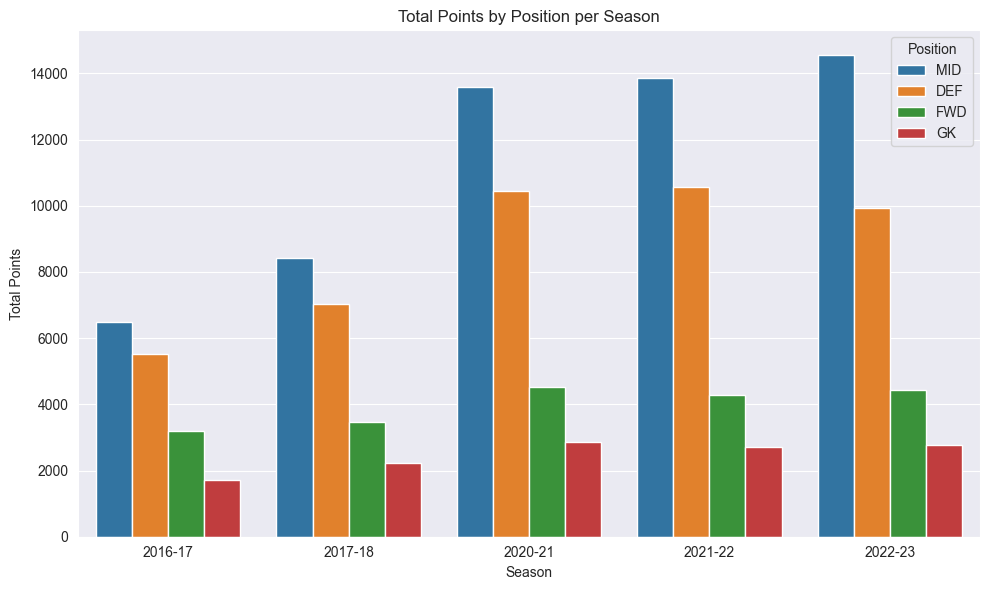

In [82]:
df_plot = (
    df_with_form_temp
    .groupby(['season_x', 'position'], as_index=False)['total_points']
    .sum()
    .sort_values(['season_x', 'total_points'], ascending=[True, False])
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_plot,
    x='season_x',
    y='total_points',
    hue='position'
)
plt.title('Total Points by Position per Season')
plt.xlabel('Season')
plt.ylabel('Total Points')
plt.legend(title='Position')
plt.tight_layout()
plt.show()


So it looks like It's always MID then DEF then FWD then finally GK but let's compute it to be sure.

Looks like we were correct to assume that.

  position  total_points
3      MID       11384.4
0      DEF        8704.0
1      FWD        3975.8
2       GK        2463.2


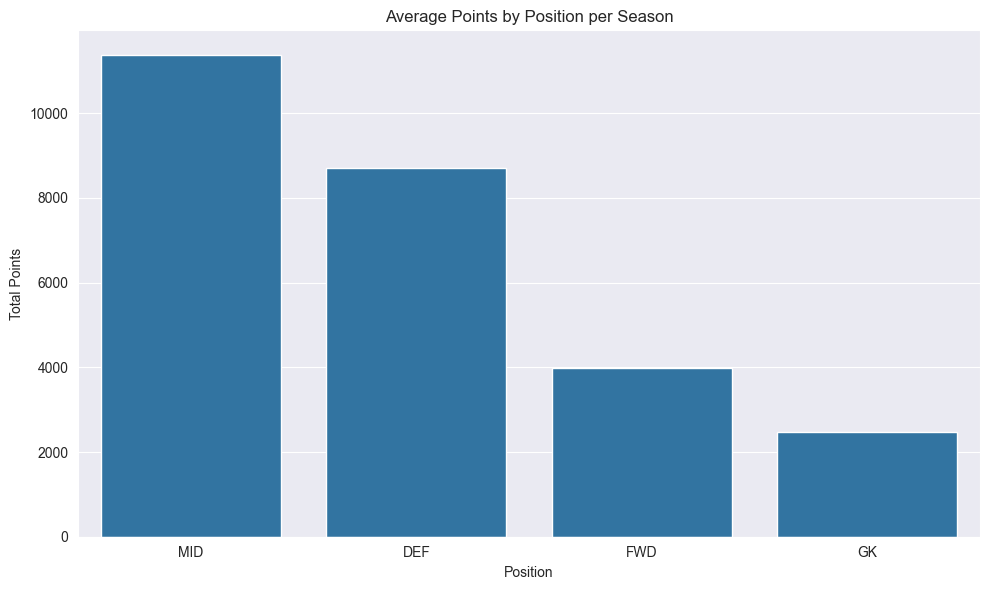

In [83]:
avg_df = (
    df_plot
    .groupby('position', as_index=False)['total_points']
    .mean()
    .sort_values(['total_points'], ascending=False)
)

print(avg_df)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=avg_df,
    x='position',
    y='total_points',
)
plt.title('Average Points by Position per Season')
plt.xlabel('Position')
plt.ylabel('Total Points')
plt.tight_layout()
plt.show()

Let's now look at how the form of the top 5 players evolved during the 22/23 Season.

Let's filter by season to get the 22-23 Season.

In [84]:
season_df = df_with_form_temp[df_with_form_temp['season_x'] == '2022-23']


Let's now identify the top 5 Players -> Let's say that the top 5 players are the top 5 players according to total_points

In [85]:
top5_players = (
    season_df.groupby('name', as_index=False)['total_points']
    .sum()
    .sort_values('total_points', ascending=False)
    .head(5)
)

print(top5_players)

                name  total_points
210   Erling Haaland           272
256       Harry Kane           263
540    Mohamed Salah           239
498  Martin Ødegaard           212
490  Marcus Rashford           205


Kinda Expected to see Haaland there haha, let's continue with the analysis

Let's track the form over the Gameweek

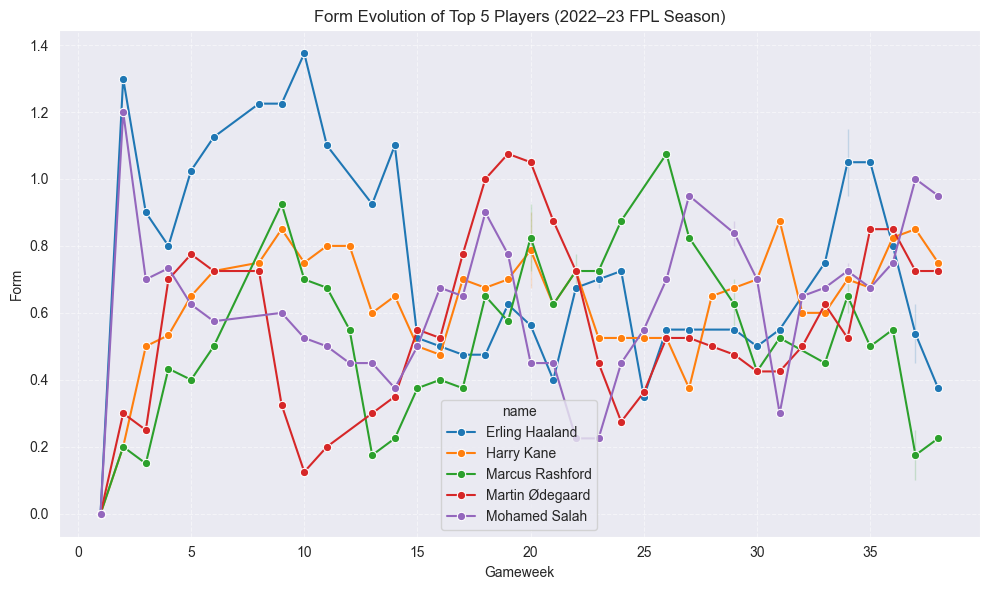

In [86]:
top5_form_df = season_df[season_df['name'].isin(top5_players['name'])]

plt.figure(figsize=(10,6))
sns.lineplot(
    data=top5_form_df,
    x='round',
    y='form',
    hue='name',
    marker='o'
)
plt.title('Form Evolution of Top 5 Players (2022–23 FPL Season)')
plt.xlabel('Gameweek')
plt.ylabel('Form')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Looks interesting, lots of fluctuations there, looks like the most consistent was Harry Kane

Let's now compute the average form per player and get the top 5 players with highest form.

In [87]:
avg_form = (
    season_df.groupby('name', as_index=False)['form']
    .mean()
    .sort_values('form', ascending=False)
)

print(avg_form.head(5))

                         name      form
210            Erling Haaland  0.742763
256                Harry Kane  0.635746
540             Mohamed Salah  0.621272
498           Martin Ødegaard  0.550658
236  Gabriel Martinelli Silva  0.546930


This shows that Players who had the highest total_points are usually the most in form.

Let's start our Data Cleaning and Feature Engineering

We start our data cleaning process by dropping unused or redundant columns. For example, 'GW' is the same as round so we drop it and we drop team_a_score and team_h_score as we used them to feature engineer above.

In [88]:
cols_to_drop = [
    "selected", "transfers_in", "transfers_out",
    "transfers_balance", "GW", 'element',
    'fixture', 'kickoff_time', 'opponent_team', 'team_a_score',
    'team_h_score', 'influence', 'opp_team_name', 'own_goals', 'creativity',
    'threat', 'team_x'
]

df_cleaned = drop_columns_save_interim(df, cols_to_drop)

Cleaned file saved to: /Users/youssefmalek/PycharmProjects/data/interim/dataset_post_drop.csv


We then normalize the position column to transform values from 'GKP' to 'GK' as both refer to the same thing.

In [89]:
df_cleaned = normalize_position_column(df_cleaned)

We encode the name column as machine learning models don't understand strings rather numbers and it is a categorical feature.

In [90]:
df_label_encoded, le_name = label_encode_column(df_cleaned, column="name")

Column 'name' label-encoded → new column 'name_encoded'


We one-hot encode our now normalized position column as it is a categorical feature and we wouldn't want the model to think that MidLaner is better than Goalkeeper if we LabelEncode and set DropFirst to true.

In [91]:
cols_to_one_hot_encode = [
    "position",
]

df_one_hot_encoded = one_hot_encode_columns(df_label_encoded, cols_to_one_hot_encode)

We map these columns from True/False to 1/0.

In [92]:
cols_to_map_to_int = [
    'was_home', 'position_FWD', 'position_MID', 'position_GK',
]

df_mapped = map_bool_to_int(df_one_hot_encoded, cols_to_map_to_int)

We add the form column.

In [93]:
df_with_form = add_form(df_mapped)

Form-added file saved to: /Users/youssefmalek/PycharmProjects/data/interim/dataset.csv


We add new features for each of these columns called lagged features. Meaning that during prediction the model can have information for the performance of a player during Game weeks before the current.

In [94]:
# cols_to_add_lag = [
#     'assists', 'bonus', 'bps', 'clean_sheets',
#     'goals_conceded', 'goals_scored', 'ict_index',
#     'minutes', 'saves', 'yellow_cards', 'ally_goals', 'opponent_goals',
# ]
#
# df_with_lagged_features = add_lag_features(df_with_form, cols_to_add_lag)

We print the Columns in our cleaned dataset.

In [95]:
print(f"Number of Columns in our cleaned dataset: {df_with_form.columns.value_counts().count()}")
print(df_with_form.columns)

Number of Columns in our cleaned dataset: 25
Index(['season_x', 'assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded',
       'goals_scored', 'ict_index', 'minutes', 'penalties_missed',
       'penalties_saved', 'red_cards', 'round', 'saves', 'total_points',
       'value', 'was_home', 'yellow_cards', 'ally_goals', 'opponent_goals',
       'name_encoded', 'position_FWD', 'position_GK', 'position_MID', 'form'],
      dtype='object')


Now we add our target feature, our Y, which is what we are trying to predict. It is just total_points shifted upwards by 1 and we drop total_points to stop model peeking!


In [96]:
df_with_target = add_upcoming_total_points(df_with_form)


BASE_FILENAME = "scaled_data"
df_scaled, scaler, scaled_cols = scale_all_numeric(
        df=df_with_target,
        filename=f"{BASE_FILENAME}_lags",
        output_subdir="interim",
        scaler_type="standard",
        exclude=["round", "upcoming_total_points"],
        save_scaler=True,
        verbose=True,
    )
# print(df_scaled.iloc[[12649]])


X, y = build_xy(df_scaled, keep_player_id=True, player_col="name_encoded")

X = X.drop(columns=['total_points'])

Saved scaler -> /Users/youssefmalek/PycharmProjects/FPL-ACL-Team-28/notebooks/data/interim/scaled_data_lags_scaler.pkl
Saved scaled columns -> /Users/youssefmalek/PycharmProjects/FPL-ACL-Team-28/notebooks/data/interim/scaled_data_lags_scaled_columns.json
Scaled DataFrame saved to: /Users/youssefmalek/PycharmProjects/FPL-ACL-Team-28/notebooks/data/interim/scaled_data_lags_scaled.csv
Columns scaled (23): ['assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded', 'goals_scored', 'ict_index', 'minutes', 'penalties_missed', 'penalties_saved', 'red_cards', 'saves', 'total_points', 'value', 'was_home', 'yellow_cards', 'ally_goals', 'opponent_goals', 'name_encoded', 'position_FWD', 'position_GK', 'position_MID', 'form']


we print data after scaling all our numeric columns and adding target

In [97]:
print("target scaled data")

print(df_scaled.head(10))
# # list-like
# print(df_scaled["position_FWD"].head(10).to_string(index=False))
# whole row, vertical (nice to read)
# print(df_scaled.iloc[12649].to_string())
#
# # whole row, one line (wide)
# print(df_scaled.iloc[[12649]].to_string(index=False))
#
# # specific columns
# print(df_scaled.iloc[12649][["penalties_missed", "penalties_saved", "position_FWD"]])





target scaled data
  season_x   assists     bonus       bps  clean_sheets  goals_conceded  \
0  2020-21 -0.190193 -0.221021 -0.923314     -0.347386        1.550514   
1  2020-21 -0.190193  3.838431  2.124345      2.878645       -0.509177   
2  2020-21 -0.190193 -0.221021 -0.415370     -0.347386        1.550514   
3  2020-21 -0.190193 -0.221021  0.092573     -0.347386        2.580360   
4  2020-21  4.459369 -0.221021  0.702104     -0.347386       -0.509177   
5  2020-21 -0.190193 -0.221021 -0.618548     -0.347386       -0.509177   
6  2020-21 -0.190193 -0.221021 -0.618548     -0.347386       -0.509177   
7  2020-21 -0.190193 -0.221021 -0.313782     -0.347386       -0.509177   
8  2020-21 -0.190193 -0.221021 -0.618548     -0.347386       -0.509177   
9  2020-21 -0.190193 -0.221021 -0.618548     -0.347386        0.520668   

   goals_scored  ict_index   minutes  penalties_missed  ...  was_home  \
0     -0.194498   0.543719  0.306719         -0.032079  ...  1.000836   
1      4.102504   1.

We split the data into 3 sets - Train, Validation and Test and we split by season so for example in our data there are 5 seasons, we split the data into Training: 3 Seasons Validation: 1 Season, Test: 1 Season to respect the temporal flow.

We note in our report the performance of the model if we follow a naive 80:10:10 split.

In [98]:
train_idx, valid_idx, test_idx, years_sorted = auto_global_temporal_split_inseason(
    df_scaled,
    season_col="season_x",
    week_col="round",
    train_frac=0.8, valid_frac=0.1, test_frac=0.1,
    split_train_valid=True, ratio_train_valid=0.8,
    split_valid_test=True, ratio_valid_test=0.5,
)

_ = summarize_round_splits(
    df=df_scaled,
    train_idx=train_idx,
    valid_idx=valid_idx,
    test_idx=test_idx,
    season_col="season_x",
    week_col="round",
)

X_train, y_train = X.loc[train_idx].copy(), y.loc[train_idx].copy()
X_valid, y_valid = X.loc[valid_idx].copy(), y.loc[valid_idx].copy()
X_test, y_test = X.loc[test_idx].copy(), y.loc[test_idx].copy()


Round allocation by season (min–max rounds per subset):
  2016-17: TRAIN 1–37 (37) | VALID — (0) | TEST — (0) | order_ok=True
  2017-18: TRAIN 1–37 (37) | VALID — (0) | TEST — (0) | order_ok=True
  2020-21: TRAIN 1–38 (38) | VALID — (0) | TEST — (0) | order_ok=True
  2021-22: TRAIN 1–30 (30) | VALID 31–38 (8) | TEST — (0) | order_ok=True
  2022-23: TRAIN — (0) | VALID 1–19 (18) | TEST 20–38 (19) | order_ok=True


Let's drop the name column as we won't use it in the rest of our pipeline only for checking performance on seen players vs non-seen players during training - the Cold Start Problem

In [99]:
train_names = X_train["name_encoded"].copy()
test_names = X_test["name_encoded"].copy()

X_train = X_train.drop(columns=["name_encoded"], errors="ignore")
X_valid = X_valid.drop(columns=["name_encoded"], errors="ignore")
X_test = X_test.drop(columns=["name_encoded"], errors="ignore")



In [100]:
print(f"Seasons by start year (chronological): {years_sorted}")
print(f"Train rows: {len(X_train)}, Valid rows: {len(X_valid)}, Test rows: {len(X_test)}")

Seasons by start year (chronological): [2016, 2017, 2020, 2021, 2022]
Train rows: 61683, Valid rows: 17251, Test rows: 14452


Let's train a FFNN on our Data and evaluate it.

We use early stopping to avoid training without validation MAE improvement and we output our metrics for R2, RMSE, MSE and MAE

In [103]:
model_ffnn, history = train_ffnn(X_train, y_train, X_valid, y_valid)
baseline_report = evaluate_model(model_ffnn, X_test, y_test, X_train, y_train, X_valid, y_valid)


📊 Evaluation Metrics:
  TRAIN:  MAE=1.2769  RMSE=2.2251  R2=0.2809
  VALID:  MAE=1.0892  RMSE=2.0473  R2=0.2940
  TEST:  MAE=0.9761  RMSE=1.8995  R2=0.3064


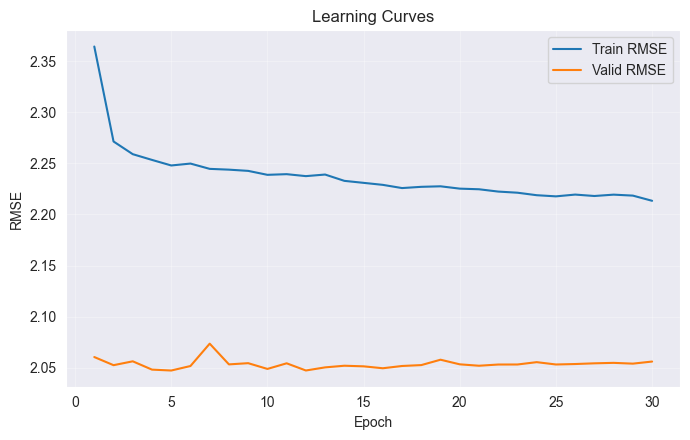

In [104]:
plot_learning_curves(model_ffnn)

We also report on the metrics of seen players vs unseen players in the test dataset.

In [34]:
seen_players = set(train_names.unique())
test_seen_mask = test_names.isin(seen_players)
test_cold_mask = ~test_seen_mask

print("\n Test composition:")
print(f"  Seen players rows:      {int(test_seen_mask.sum())}")
print(f"  Cold-start players rows: {int(test_cold_mask.sum())}")

def eval_subset(model, X_te, y_te, mask, label: str):
    n = int(mask.sum())
    if n == 0:
        print(f"{label}: no rows.")
        return

    metrics = evaluate_model(model, X_te[mask], y_te[mask])
    print(f"{label}: n={n} | {metrics}")

print("\nFFNN — Seen vs Cold-start:")
eval_subset(model_ffnn, X_test, y_test, test_seen_mask, "TEST (seen players)")
eval_subset(model_ffnn, X_test, y_test, test_cold_mask, "TEST (cold-start players)")


 Test composition:
  Seen players rows:      8687
  Cold-start players rows: 5765

FFNN — Seen vs Cold-start:

📊 Evaluation Metrics:
  TEST:  MAE=1.0630  RMSE=2.0115  R2=0.2980
TEST (seen players): n=8687 | {'test': {'MAE': 1.0630167780809179, 'MSE': 4.046239722647122, 'RMSE': 2.0115267143757056, 'R2': 0.2980044324030209}}

📊 Evaluation Metrics:
  TEST:  MAE=0.8226  RMSE=1.7129  R2=0.3174
TEST (cold-start players): n=5765 | {'test': {'MAE': 0.8226336776880678, 'MSE': 2.9340034091157556, 'RMSE': 1.7128932859684387, 'R2': 0.3173720158401775}}


Now we choose the 3 local rows with the biggest errors to explain or we can manually choose a row

In [35]:
# rows_ffnn = pick_rows_for_explanations(model_ffnn, X_test, y_test, k=3)


we call run_explainability to produce SHAP and LIME explanations for model_ffnn  using X_train, X_test, using row 12649 a mid player.We use 800 samples as background.

In [32]:
# Then run explainability
feature_names = list(X_train.columns)
run_explainability(
    model=model_ffnn,
    model_name="ffnn",
    X_train=X_train,
    X_test=X_test,
    feature_names=feature_names,
    local_rows=[12649],
    do_shap=True,
    do_lime=True,
)

KeyboardInterrupt: 

In [36]:
baseline_valid = baseline_report['valid']['MAE']
print(baseline_valid)

1.0785338139224847


In [40]:
BASE_COLS_TO_DROP = [
    "selected", "transfers_in", "transfers_out",
    "transfers_balance", "GW", 'element',
    'fixture', 'kickoff_time', 'opponent_team', 'team_a_score',
    'team_h_score', 'influence', 'opp_team_name', 'own_goals', 'creativity',
    'threat', 'team_x'
]

results = []

results.append(run_one("baseline"))

for col in BASE_COLS_TO_DROP:
    cols_override = [c for c in BASE_COLS_TO_DROP if c != col]
    results.append(run_one(f"add_back__{col}", cols_to_drop_override=cols_override))

results.append(run_one("no_lags", cols_to_drop_override=None, use_form=True, use_lags=False))

results.append(run_one("no_form", cols_to_drop_override=None, use_form=False, use_lags=True))

results.append(run_one("no_form_no_lags", cols_to_drop_override=None, use_form=False, use_lags=False))

results.append(run_no_position_dummies())

df_ablate = pd.DataFrame(results)

baseline_mae = float(df_ablate.loc[df_ablate["label"]=="baseline","valid_MAE"].iloc[0])
df_ablate["Δ_valid_MAE_vs_baseline"] = df_ablate["valid_MAE"] - baseline_mae
df_ablate = df_ablate.sort_values("Δ_valid_MAE_vs_baseline")

print("\n=== Ablation results (lower is better) ===")
print(df_ablate.to_string(index=False))

Cleaned file saved to: /Users/youssefmalek/PycharmProjects/data/interim/dataset_post_drop.csv
Column 'name' label-encoded → new column 'name_encoded'
Form-added file saved to: /Users/youssefmalek/PycharmProjects/data/interim/dataset.csv

📊 Evaluation Metrics:
  TRAIN:  MAE=1.2385  RMSE=2.2424  R2=0.2697
  VALID:  MAE=1.0610  RMSE=2.0536  R2=0.2896
  TEST:  MAE=0.9492  RMSE=1.9032  R2=0.3036
[baseline] valid_MAE=1.0610, test_MAE=0.9492
Cleaned file saved to: /Users/youssefmalek/PycharmProjects/data/interim/dataset_post_drop.csv
Column 'name' label-encoded → new column 'name_encoded'
Form-added file saved to: /Users/youssefmalek/PycharmProjects/data/interim/dataset.csv

📊 Evaluation Metrics:
  TRAIN:  MAE=1.4043  RMSE=2.8175  R2=-0.1529
  VALID:  MAE=1.1840  RMSE=2.5241  R2=-0.0732
  TEST:  MAE=1.0705  RMSE=2.3476  R2=-0.0595
[add_back__selected] valid_MAE=1.1840, test_MAE=1.0705
Cleaned file saved to: /Users/youssefmalek/PycharmProjects/data/interim/dataset_post_drop.csv
Column 'name' l